In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import pystan
import arviz
from scipy.stats import logistic

import sys
sys.path.append("../src")

import preprocess_data

#### Fake data

In [224]:
def simulate_games(a_1, a_2, sigma_a, sigma_y, cutpoints, num_games):
    """3 is player 1 wins, 2 a draw, 1 is player 2 wins"""
    a_1_sims = np.random.normal(a_1, sigma_a, size=num_games)
    a_2_sims = np.random.normal(a_2, sigma_a, size=num_games)
    sim_y = logistic(a_1_sims - a_2_sims, sigma_y).rvs(num_games)
    player_1_wins = sim_y > cutpoints[1]
    player_1_lose = sim_y < cutpoints[0]
    y = np.ones(num_games)*2
    y[player_1_wins] = 3
    y[player_1_lose] = 1
    return y

In [286]:
sigma_a = 0.25
sigma_y = 1
cutpoints = [-1.25, 0.75]

In [287]:
relative_abilities = [1, 0.8, 0.5, 0.4, 0, -0.2, -0.5, -0.75]
relative_abilities = np.linspace(1, -1, 11)
num_players = len(relative_abilities)

In [288]:
num_games = 10_000
p1, p2, outcomes = [], [], []
for i in range(num_games):
    player_1, player_2 = random.sample(range(num_players), k=2)
    player_1_ability, player_2_ability = relative_abilities[player_1], relative_abilities[player_2]
    y_game = simulate_games(player_1_ability, player_2_ability, sigma_a, sigma_y, cutpoints, 1).astype(int)[0]
    p1.append(player_1)
    p2.append(player_2)
    outcomes.append(y_game)

In [289]:
df = pd.DataFrame({"p1_index": p1, "p2_index": p2, "y": outcomes})
df["p1_rank"] = df["p1_index"] + 1
df["p2_rank"] = df["p2_index"] + 1

In [290]:
prior_fake = np.arange(num_players, 0, -1)
prior_score_fake = (prior_fake - np.mean(prior_fake)) / (2 * np.std(prior_fake, ddof=1))

### Set-up model

In [163]:
#model = pystan.StanModel("../stan_models/fake_data_model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8a4acf2ae70e49ddd56ebc95e7c7c0b7 NOW.


In [291]:
stan_data = {
    "num_players": num_players,
    "num_games": len(df),
    "K": 3,
    "prior_score": prior_score_fake,
    "player_1_rank": df["p1_rank"].values,
    "player_2_rank": df["p2_rank"].values,
    "y": df["y"].values,   
}

In [292]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [293]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = arviz.summary(inference_data).reset_index().rename(columns={"index":"parameter"})

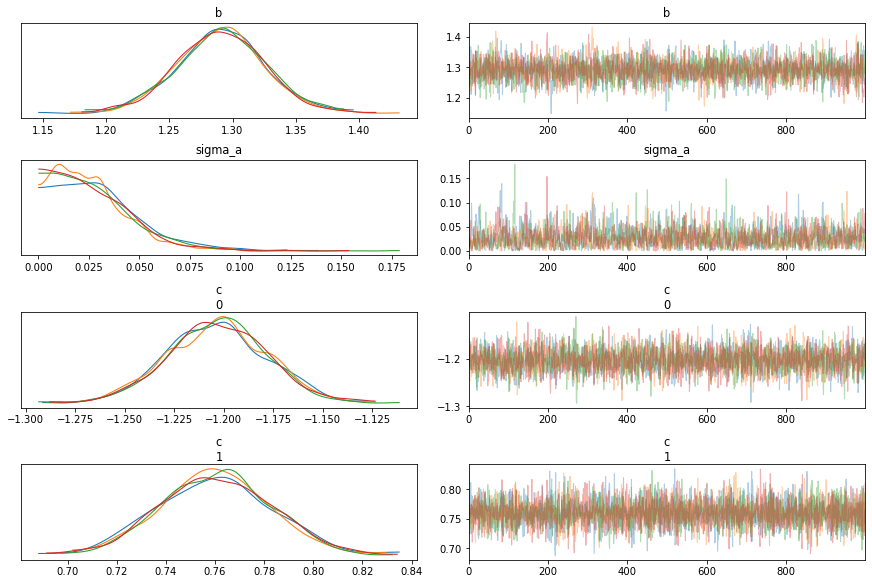

In [294]:
arviz.plot_trace(inference_data, var_names=["b", "sigma_a", "c"]);

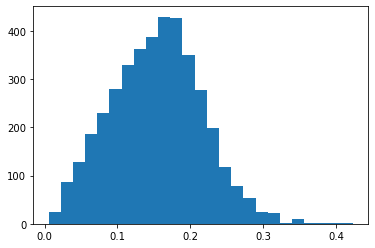

In [304]:
plt.hist(params["sigma_a"]**0.5, bins=25);

In [295]:
params["c"].mean(0)

array([-1.20323844,  0.76039035])

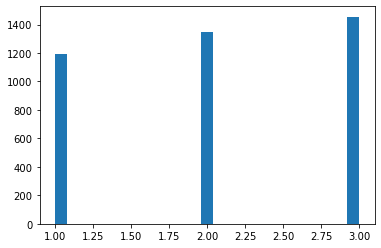

In [283]:
plt.hist(params["ypred"][:, 2], bins=25);

In [284]:
df.head()

,p1_index,p2_index,y,p1_rank,p2_rank
0,2,6,1,3,7
1,9,7,3,10,8
2,6,7,3,7,8
3,0,1,1,1,2
4,2,10,3,3,11


### Plotting

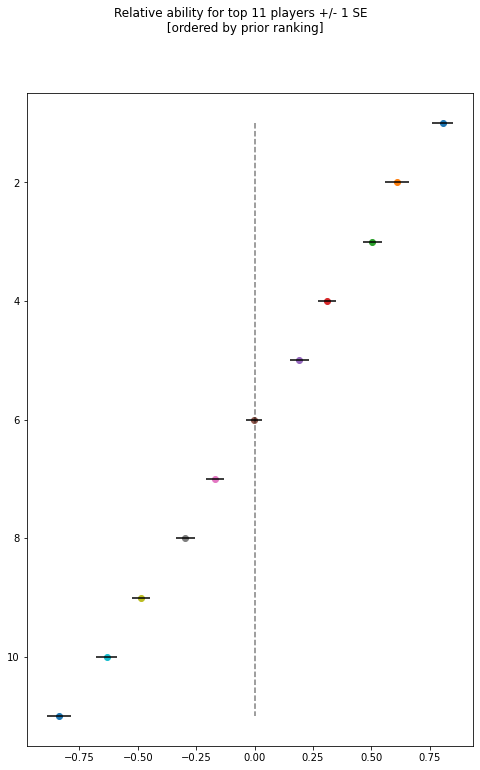

In [185]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = num_players

for i in range(plot_top_n_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();
plt.suptitle(f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]");


In [186]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out/np.mean(out.sum(1))

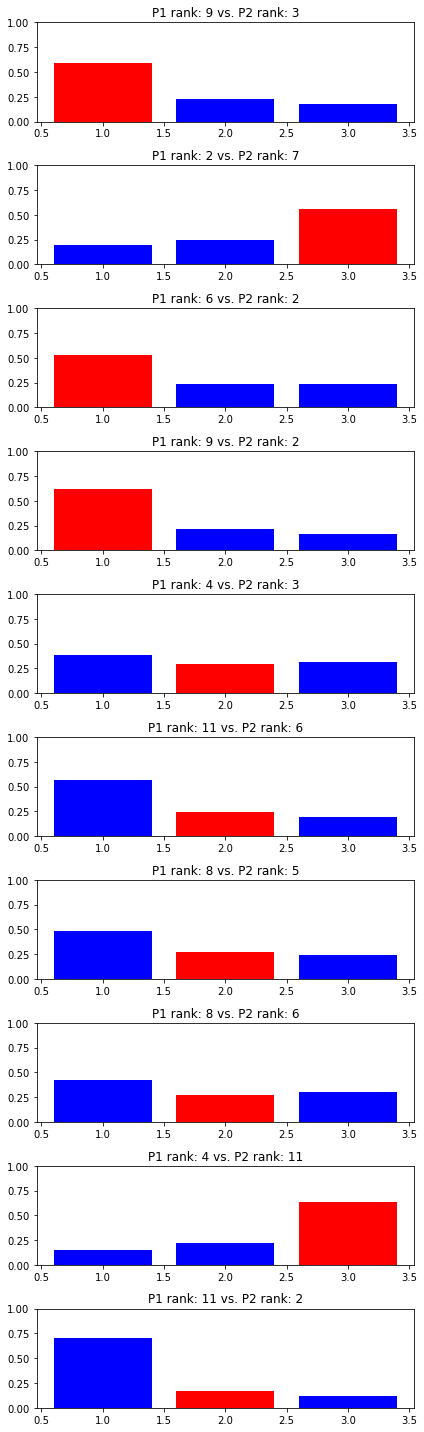

In [190]:
plot_n = 10
reverse = False
colors = ["blue"]*3

ranks = [f"P1 rank: {a} vs. P2 rank: {b}" for a, b in zip(df["p1_rank"], df["p2_rank"])]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[df["y"][i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors);
    ax[i].set_title(f"{ranks[i]}");
    ax[i].set_ylim(0, 1);
plt.tight_layout();

In [191]:
cls_pred = np.argmax(out_prob, 1) + 1

In [195]:
np.mean(np.abs(df["y"] - cls_pred) == 0)

0.513

In [196]:
np.mean(np.abs(df["y"] - cls_pred) == 1)

0.2496

In [197]:
np.mean(np.abs(df["y"] - cls_pred) == 2)

0.2374